Author: Thibeau Wouters

$\textbf{IMPORTANT MESSAGE:}$ I have noticed that the output of the Metropolis algorithm below can sometimes vary from run to run: this is probably simply due to the randomness involved in Monte Carlo algorithms. I have therefore saved some of the data that I used to obtain plots that are shown in the report such that they can easily be recreated (in case I want to edit the plots, but don't want to re-run everything again and check if the output is still good). 

I provide a brief overview of the files which are saved externally and loaded into variables in this notebook. All these files can be loaded into the notebook by using the pickle package: see later on in the notebook.
- msweeps1, final1: Magnetisations after 200 sweeps of the Metropolis algorithm at $T = 0.2$ and the final lattice configuration.
- msweeps2, final2: Magnetisations after 500 sweeps of the Metropolis algorithm at $T = 2$ and the final lattice configuration. These magnetisations were obtained by starting the Metropolis algorithm with final1 as initial lattice configuration. After a few sweeps (see plots below), the algorithm has reached an equilibrium. Hence we can start running the Metropolis algorithm from final2 if we want to sample for example energies when the equilibrium for $T = 2$ is reached, as is done below. We also start from final2 as initial configuration to quickly reach equilibrium for $T = 2.2$ in the last part of this problem.
- msweeps3, final3: Magnetisations after 1000 sweeps of the Metropolis algorithm at $T = 2.2$ and the final lattice configuration, starting from final2 as the initial lattice configuration. Equilibrium for $T = 2.2$ is reached during this run, so we can start from final3 to explore the physics around this equilibrium.
- msweeps4, final4: Magnetisations after 3000 sweeps of the Metropolis algorithm at $T = 2.2$ and the final lattice configuration, starting from final3 as the initial lattice configuration. The magnetisations msweeps4 are used in the exercise about the autocorrelation function.
- energies: Contains 4000 samples of the total energy of lattice configurations, obtained after equilibrium for $T = 2$ has been reached by running the Metropolis algorithm with final2 as initial lattice configuration.

##### Imports:

In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
import scipy.integrate as integrate
import copy
import time

##### Configurate matplotlib settings

In [2]:
plt.style.use('ggplot')
plt.rcParams.update(
    {"text.usetex": True,
     'font.serif': 'Modern Roman',
     "figure.figsize": (10, 8),
     "legend.fontsize":18,
    "axes.titlesize" : 26,
    "axes.labelsize" : 28,
    "lines.linewidth": 3,
    "lines.markersize" : 10,
    "xtick.labelsize" : 24,
    "ytick.labelsize" : 24})

##### Functions:

In [3]:
def random_spins(N):
    '''Generate a N x N random lattice of spins, represented as a vector of length N^2.'''
    spins = [-1, 1]
    
    lattice = []
    for i in range(N**2):
        lattice.append(random.choice(spins))
    
    return lattice

In [4]:
def generate_exponentials(T):
    '''Given a temperature T, makes a dictionary with keys 4 and 8, and values exp(-4/T) andexp(-8/T).'''
    delta_E = [4, 8]
    exponentials = {}
    for E in delta_E:
        exponentials[str(E)] = np.exp(-E/T)
    
    return exponentials

In [5]:
def flip_spin(lattice, N, T, exponentials):
    '''Implements a single step of the Metropolis algorithm. Proposes to flip a spin, and updates
        the lattice if the spin is indeed flipped.'''
    i = random.randint(0, N**2 - 1) # choose a lattice point at random
    s = lattice[i] # get the spin at that lattice point
    
    # Initial energy - note: we only need to look at the 4 nearest neighbours to get Delta E
    E_i = 0
    E_i += - s*lattice[(i + N + N**2)%N**2]
    E_i += - s*lattice[(i -  N + N**2)%N**2]
        
    E_i += - s*lattice[(i + 1 + N**2)%N**2]
    E_i += - s*lattice[(i -  1 + N**2)%N**2]
    
    
    # Final energy and difference in energy: see report for details
    E_f = - E_i
    delta_E = -2*E_i
    
    # If Delta E is negative: accept
    if delta_E <= 0:
        lattice[i] = -s
        return lattice
    
    # If Delta E is positive: 'flip a coin' and ...
    r = random.uniform(0, 1)
    key = str(delta_E)

    # ... accept the flip
    if r <= exponentials[key]:
        lattice[i] = -s
        return lattice
    
    # ... or not: return lattice; if this is reached, lattice has not been changed
    return lattice

In [6]:
def compute_energy(lattice, N):
    '''Given a lattice, computes the energy per bond according to Hamiltonian for the Ising model.'''
    E = 0
    
    for i in range(len(lattice)):
        s = lattice[i]
        E += -s*lattice[(i + N + N**2)%N**2]
        E += -s*lattice[(i -  N + N**2)%N**2]
        
        E += -s*lattice[(i + 1 + N**2)%N**2]
        E += -s*lattice[(i -  1 + N**2)%N**2]
    
    # We counted double: divide by two AND return energy per bond (intensive variable)
    return E/(4*N**2)

In [7]:
def compute_magnetisation(lattice, N):
    '''Given a lattice, compute the magnetisation as defined in the Problem.'''
    return abs(np.sum(lattice))/(N**2)

In [8]:
def iteration_magnetisation(N, T, nsweeps, initial_state = False, sample_energies = False):
    '''Generates a N x N lattice or starts from a given lattice and performs the Metropolis algorithm for nsweeps sweeps.
        If initial_state is not False, it is a lattice that has to be taken as initial state.
        If sample_energies is True, also store the energy per bond of the lattice at each sweep.'''
    
    # --- Prepare for the iterations ---
    
    # Count how many MC steps are done: we compute something at each sweep = N^2 MC steps.
    counter = 0
    
    
    # If no initial state is given, generate a random lattice
    if initial_state == False:
        lattice = random_spins(N)
    
    else:
        lattice = copy.deepcopy(initial_state) # we make a copy, such that things don't get messed up!
    
    # Compute the exponentials for Metropolis (see report for details)
    exponentials = generate_exponentials(T)

    # Compute magnetisation and (if asked) energy of initial configuration
    m_list = [compute_magnetisation(lattice, N)]
    if sample_energies == True:
        energies = [compute_energy(lattice, N)]
    
    # --- Start the algorithm ---
    nreps = nsweeps*(N**2)
    
    # Flip the spins and compute magnetisation each sweep    
    for i in range(nreps):
        new_lattice = flip_spin(lattice, N, T, exponentials)
        counter += 1
        
        # To reduce computation time, only compute after a sweep is done: 1 sweep = N**2 MC steps
        if counter%N**2 == 0:
            m_list.append(compute_magnetisation(new_lattice, N))
            
            if sample_energies == True:
                energies.append(compute_energy(new_lattice, N))
        
        lattice = new_lattice
        
    # Return all the magnetisations and the final state, so that we can start from the final state if we want to continue
    if sample_energies == False:
        return (m_list, lattice)
    
    if sample_energies == True:
        return (m_list, energies, lattice)

In [9]:
def exact_magnetisation(T):
    '''Computes the exact value of magnetisation, given T.'''
    return (1 - (np.sinh(2/T))**(-4))**(1/8)

In [10]:
def autocorrelation_function(m_list, t):
    '''Computes the autocorrelation function at a time t (see equation (92) in lecture notes).'''
    average_m = np.mean(m_list)
    s = 0 # the final sum
    
    # To get the average: count how many terms are in the sum (this can vary: index has to be well defined)
    counter = 0 
    
    for i in range(len(m_list)):
        if i+t < len(m_list ): # index has to be well defined!
            s += (m_list[i] - average_m)*(m_list[i+t] - average_m)
            counter += 1
    
    return s/counter

In [11]:
# Critical temperature
#TC = 2/np.log(1 + np.sqrt(2))
#print('The critical temperature is ', TC)

# 8 - Metropolis Algorithm for the Ising Model

## 8.1 - Magnetisation per spin

Set-up of the problem:

In [12]:
T = 2; N = 50; 

The idea is to start from a low temperature, then gradually build up towards $T = 2$, in order to have a faster convergence.

$\textbf{IMPORTANT:}$ To compute magnetisations per spin for T = 2 - this takes some time and needs care! Computations are put in comments below, since I saved some results to external files: load these files to get the plots, I will work with them in 8.2 below.

To load and save files, I will need the pickle package.

In [13]:
import pickle

$\textbf{FIRST RUN}$

In [14]:
# # Calculate magnetisation
# start = time.time()
# m_list, final = iteration_magnetisation(N, 0.2, 200) # temperature is 0.5, number of sweeps is 500
# end = time.time()
# print('Computation time was ', end - start, ' seconds.')

In [15]:
# ## Save magnetisation per sweep
# with open('msweeps1', 'wb') as f:
#     pickle.dump(m_list, f)

# ## Save final state
# with open('final1', 'wb') as f:
#     pickle.dump(final, f)

Once the file msweeps is made and stored, it can be loaded using pickle. Make sure pickle is imported, and the files have correct names.

In [16]:
with open('msweeps1', 'rb') as f:
    msweeps1 = pickle.load(f)
    
with open('final1', 'rb') as f:
    final1 = pickle.load(f)

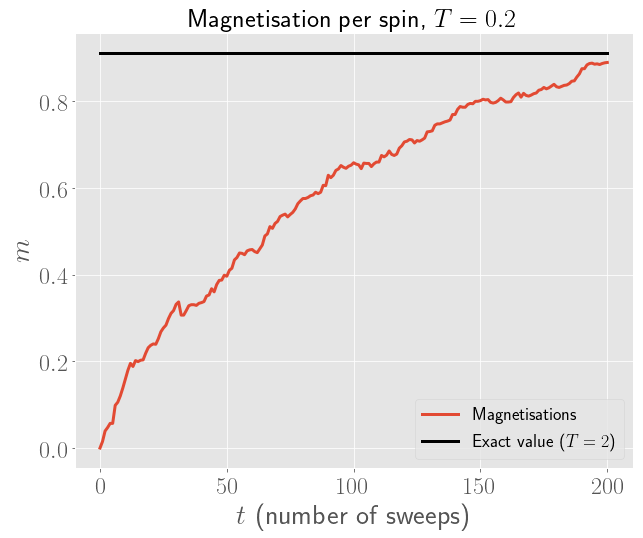

In [17]:
# Plot the result

plt.plot(msweeps1, label = 'Magnetisations')

# Plot exact value
t = np.arange(0, len(msweeps1), 1)
m_exact = exact_magnetisation(T) # T = 2
y = [m_exact for val in t]
plt.plot(t, y, color = 'black', label = r'Exact value ($T=2$)')

# Make fancy, save and show:
plt.xlabel(r'$t$ (number of sweeps)')
plt.ylabel(r'$m$')
plt.legend()
plt.title('Magnetisation per spin, $T = 0.2$')
plt.show()

## 8.2 - Estimate of the equilibration time

We are now ready to start convering towards the expected magnetisation. That is, we now set $T = 2$ and let the algorithm start from the previous final state.

In [18]:
# Calculate magnetisation
start = time.time()
# Temperature is final temp, number of sweeps is 2000, start from previous one
m_list, final = iteration_magnetisation(N, 2, 500, initial_state = final1) 
end = time.time()
print('Computation time was ', end - start, ' seconds.')

Computation time was  7.353485345840454  seconds.


Take a look at the plot to estimate the equilibration time if we start from final1.

In [19]:
msweeps = msweeps1 + m_list

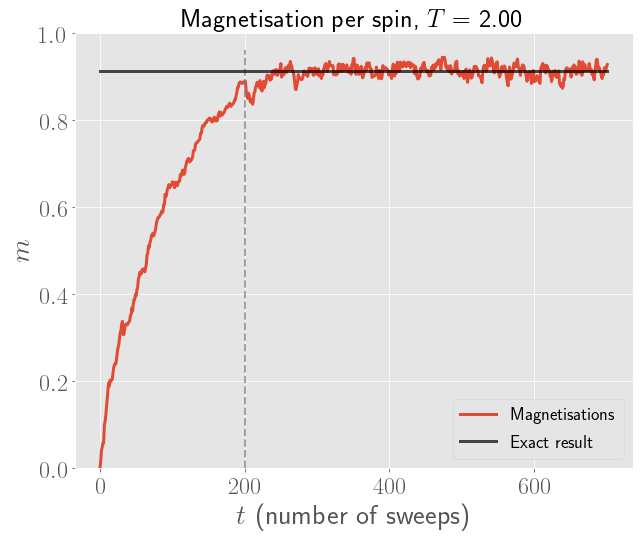

In [20]:
# Plot the result

plt.plot(msweeps, label = 'Magnetisations')

# Plot a vertical line
t = np.arange(0, 0.97, 0.01)
x = [200 for val in t]

plt.plot(x, t, color = 'grey', alpha = 0.7, linestyle = '--', lw = 2)

# Plot exact value

t = np.arange(0, len(msweeps), 1)
m_exact = exact_magnetisation(T) # T = 2
y = [m_exact for val in t]
plt.plot(t, y, color = 'black', alpha = 0.7, label = 'Exact result')

# Make fancy, save and show:

plt.xlabel(r'$t$ (number of sweeps)')
plt.ylabel(r'$m$')
plt.ylim(0, 1)
plt.legend()
plt.title('Magnetisation per spin, $T = $ %0.2f' %T)
plt.savefig('ex8_magn_plot.pdf', bbox_inches = 'tight')
plt.show()

Get a close-up of the above plot.

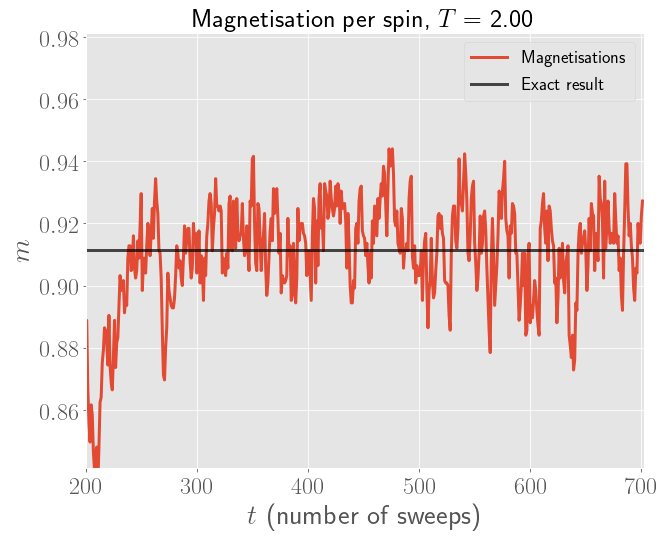

In [21]:
# Plot the result

plt.plot(msweeps, label = 'Magnetisations')

# Plot exact value

t = np.arange(0, len(msweeps), 1)
m_exact = exact_magnetisation(T) # T = 2
y = [m_exact for val in t]
plt.plot(t, y, color = 'black', alpha = 0.7, label = 'Exact result')

# Make fancy, save and show:

plt.xlabel(r'$t$ (number of sweeps)')
plt.ylabel(r'$m$')
plt.ylim(m_exact - 0.07, m_exact + 0.07)
plt.xlim(200, len(msweeps))
plt.legend()
plt.title('Magnetisation per spin, $T = $ %0.2f' %T)
plt.savefig('ex8_magn_plot_closeup.pdf', bbox_inches = 'tight')
plt.show()

## 8.3 - Histogram of the energies

The idea: the first 1500 sweeps and corresponding magnetisations correspond to the 'building up' of the temperature. However, the above code can sometimes be runned, and the magnetisations do not converge towards the correct exact value. Therefore, I will start from the lattice configuration final1, and then run the Metropolis algorithm at $T = 2$ a thousand times, and only then start sampling the energies at each sweep.

$\textbf{FIRST RUN: equilibration of the system}$

In [22]:
# # Let the system equilibrate

# start = time.time()
# m_list, final = iteration_magnetisation(N, 2, 500, initial_state = final1) 
# end = time.time()
# print('Computation time was ', end - start, ' seconds.')

Save the magnetisations and final state.

In [23]:
# ## Save magnetisation per sweep
# with open('msweeps2', 'wb') as f:
#     pickle.dump(m_list, f)

# ### Save final state
# with open('final2', 'wb') as f:
#     pickle.dump(final, f)

Load the data (afterwards):

In [24]:
with open('msweeps2', 'rb') as f:
    msweeps2 = pickle.load(f)
    
with open('final2', 'rb') as f:
    final2 = pickle.load(f)

Check graphically if equilibrium is indeed reached.

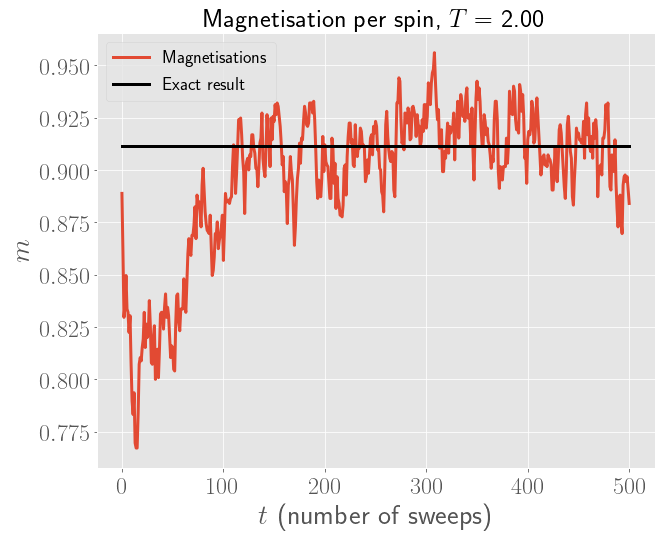

In [25]:
# Plot the result

plt.plot(msweeps2, label = 'Magnetisations')

# Plot exact value

t = np.arange(0, len(msweeps2), 1)
m_exact = exact_magnetisation(T) # T = 2
y = [m_exact for val in t]
plt.plot(t, y, color = 'black', label = 'Exact result')

# Make fancy, save and show:

plt.xlabel(r'$t$ (number of sweeps)')
plt.ylabel(r'$m$')
plt.legend()
plt.title('Magnetisation per spin, $T = $ %0.2f' %T)
plt.show()

This looks good. This means that we can start from final2 if want to explore the physics around the equilibrium for $T = 2$. This will certainly help us in the last part of this Problem, where we need to converge towards the equilibrium for $T = 2.2$.

$\textbf{SECOND RUN: sample energies}$

Depending on how many samples one wants, this can take some time. Hence I have saved a file containing energies, obtained after running the code below.

In [26]:
# # System is in equilibrium - sample energies

# start = time.time()
# # Temperature is final temp, start from the previous
# m_list, energies, final = iteration_magnetisation(N, 2, 4000, initial_state = final2, sample_energies = True) 
# end = time.time()
# print('Computation time was ', end - start, ' seconds.')

Save only the energies, since we won't need the magnetisations or the final state for another exercise after this.

In [27]:
# # Save sampled energies
# with open('energies', 'wb') as f:
#     pickle.dump(energies, f)

Load the data (afterwards):

In [28]:
with open('energies', 'rb') as f:
    energies = pickle.load(f)    

Make the histogram.

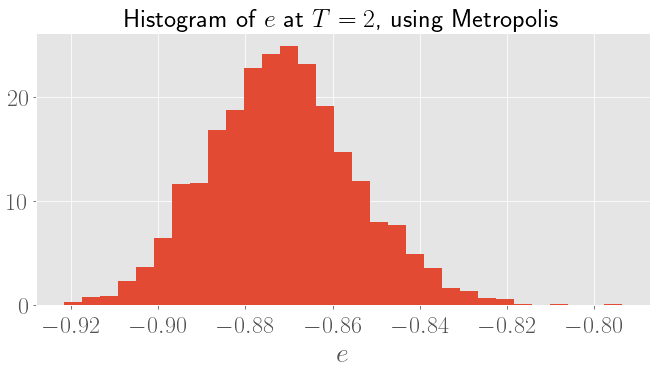

In [29]:
plt.subplots(figsize = (11, 5))
plt.hist(energies, density = True, bins = 31)

# Make fancy, save and show
plt.xlabel(r'$e$')
plt.title(r'Histogram of $e$ at $T = 2$, using Metropolis')
## Uncomment the next line to save the plot
#plt.savefig('ex8_histogram_energies.pdf', bbox_inches = 'tight')
plt.show()

## 8.4 - Autocorrelation time

We do this for $T = 2.2$, $N = 50$. We can start from final2, in which equilibrium for $T = 2$ was reached, to converge towards the equilibrium of $T = 2.2$.

$\textbf{FIRST RUN: equilibration of the system}$

We have final2 as an external file in which we are around the exact value for the magnetisation per spin, for $T = 2$. We can start from this to equilibrate towards the exact value of magnetisation per spin for $T = 2.2$, since we have to start sampling for $t > \tau_{eq}$.

Again: to make it easier, a run of the code below is saved in an external file: load it using Pickle below.

In [30]:
# # Let the system equilibrate

# start = time.time()
# m_list, final = iteration_magnetisation(N, 2.2, 1000, initial_state = final2) 
# end = time.time()
# print('Computation time was ', end - start, ' seconds.')

Save the magnetisations and final state.

In [31]:
# ## Save magnetisation per sweep
# with open('msweeps3', 'wb') as f:
#     pickle.dump(m_list, f)

# ### Save final state
# with open('final3', 'wb') as f:
#     pickle.dump(final, f)

Load the data (afterwards):

In [32]:
with open('msweeps3', 'rb') as f:
    msweeps3 = pickle.load(f)
    
with open('final3', 'rb') as f:
    final3 = pickle.load(f)

Check graphically if equilibrium is indeed reached.

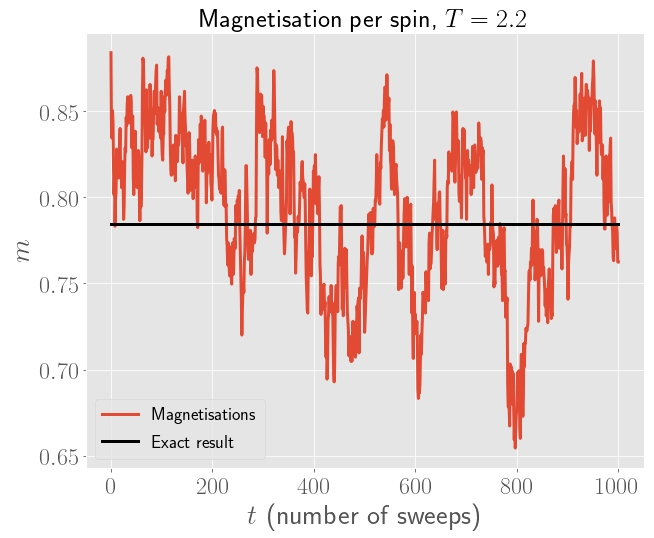

In [33]:
# Plot the result
plt.plot(msweeps3, label = 'Magnetisations')

# Plot exact value
t = np.arange(0, len(msweeps3), 1)
m_exact = exact_magnetisation(2.2)
y = [m_exact for val in t]
plt.plot(t, y, color = 'black', label = 'Exact result')

# Make fancy, save and show:
plt.xlabel(r'$t$ (number of sweeps)')
plt.ylabel(r'$m$')
plt.legend()
plt.title('Magnetisation per spin, $T = 2.2$')
#plt.savefig()
plt.show()

$\textbf{SECOND RUN: start collecting magnetisations}$

Depending on how many samples one wants, this can take some time. Load external file via pickle.

In [34]:
# # System is in equilibrium - sample magnetisations

# start = time.time()
# # Temperature is final temp, start from the previous
# m_list, final = iteration_magnetisation(N, 2.2, 3000, initial_state = final3) 
# end = time.time()
# print('Computation time was ', end - start, ' seconds.')

Save the magnetisations and final state.

In [35]:
# ## Save magnetisation per sweep
# with open('msweeps4', 'wb') as f:
#     pickle.dump(m_list, f)

# ### Save final state
# with open('final4', 'wb') as f:
#     pickle.dump(final, f)

Load the data (afterwards):

In [36]:
with open('msweeps4', 'rb') as f:
    msweeps4 = pickle.load(f)
    
with open('final4', 'rb') as f:
    final4 = pickle.load(f)

In [37]:
# Compute the autocorrelation function for t <= t_final
chi_list = []; t_final = 300
for t in range(t_final):
    chi_list.append(autocorrelation_function(msweeps4, t))

chi_data = np.array(chi_list)

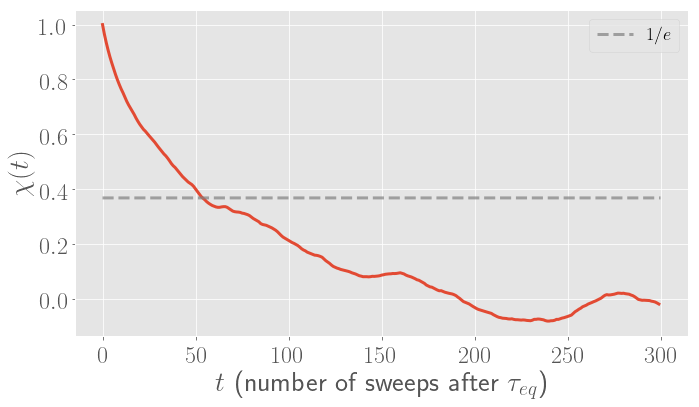

In [38]:
# Normalise the data by dividing by chi(0)
chi = chi_data/chi_data[0]

# Make a plot of the data
plt.subplots(figsize = (11, 6))
plt.plot(chi)

# Plot 1/e to determine the autocorrelation time
t = np.arange(0, t_final, 0.1)
val = np.exp(-1)
y = [val for time in t]
plt.plot(t, y, color = 'grey', linestyle = '--', alpha = 0.7, label = r'$1/e$')

# Make fancy, save and show
plt.xlabel(r'$t$ (number of sweeps after $\tau_{eq}$)')
plt.ylabel(r'$\chi(t)$')
plt.legend()
## Uncomment the next line to save the plot
#plt.savefig('ex8_autocorrelation_function.pdf', bbox_inches = 'tight')
plt.show()    

Make a fit to estimate the autocorrelation time. We need Scipy to fit. We can use the plot above to make an estimation of the fit parameters.

In [39]:
import scipy

Make a slice of the data if wanted: at larger times, there is noise in the data.

In [40]:
chi_sliced = chi[:120]

In [41]:
x = np.array([i for i in range(len(chi_sliced))])

[a_opt, b_opt], pcov = scipy.optimize.curve_fit(lambda t,a,b: a*np.exp(-(1/b)*t),  x , chi_sliced,  p0=(1, 35))
print('The optimal values for the parameters are a = %0.4f and b = %0.4f' %(a_opt, b_opt))
print('The covariance matrix for the parameters is ', pcov)

The optimal values for the parameters are a = 0.8971 and b = 66.0268
The covariance matrix for the parameters is  [[ 4.22798999e-05 -3.89077055e-03]
 [-3.89077055e-03  6.46097925e-01]]


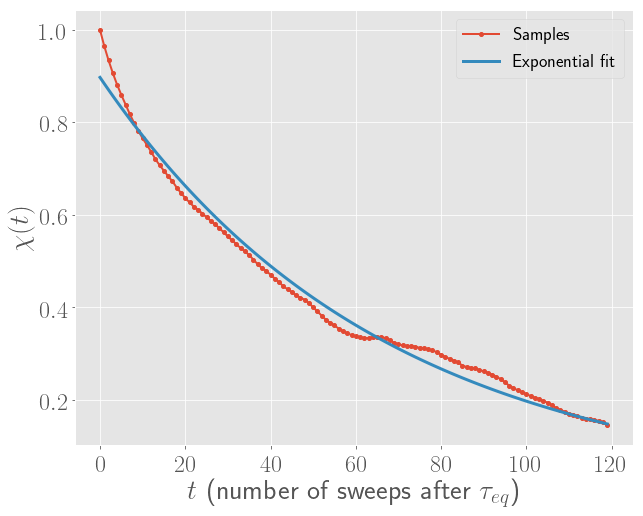

In [42]:
# Plot samples & fit
plt.plot(chi_sliced, marker = 'o', label = 'Samples', lw = 2, markersize = 4)
y = a_opt*np.exp(-(1/b_opt)*x)
plt.plot(x, y, label = 'Exponential fit')

# Make fancy, save and show:
plt.legend()
plt.xlabel(r'$t$ (number of sweeps after $\tau_{eq}$)')
plt.ylabel(r'$\chi(t)$')
## Uncomment the next line to save the plot
#plt.savefig('ex8_autocorrelation_function_fit.pdf', bbox_inches = 'tight') # won't be included in the report
plt.show()

In [43]:
print('The autocorrelation time estimed from the fit is ', b_opt)

The autocorrelation time estimed from the fit is  66.02677089968655


Is this value reasonable? Take a look at the plot of the magnetisations on which these results are based: this is file msweeps4.

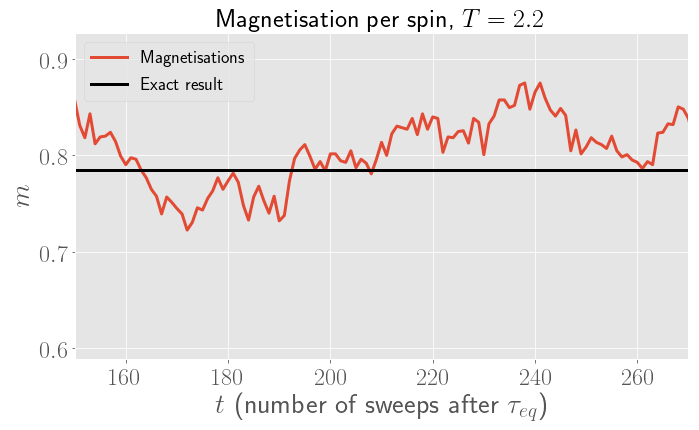

In [44]:
# Plot the result
plt.subplots(figsize = (11, 6))
plt.plot(msweeps4, label = 'Magnetisations')

# Plot exact value

t = np.arange(0, len(msweeps4), 1)
m_exact = exact_magnetisation(2.2)
y = [m_exact for val in t]
plt.plot(t, y, color = 'black', label = 'Exact result')

# Make fancy, save and show:
plt.xlim(150, 270)
plt.xlabel(r'$t$ (number of sweeps after $\tau_{eq}$)')
plt.ylabel(r'$m$')
plt.legend()
plt.title('Magnetisation per spin, $T = 2.2$')
plt.savefig('ex8_autocorr_check_magn.pdf', bbox_inches = 'tight')
plt.show()